# StubHub Ticket Pricing Optimization for Effective Arbitrage
### A.K.A. ScalperBot™ 🤖

## <i>Arbitrage</i> is the behavior of buying in one market and simultaneously selling in another, profiting from a temporary difference. 

#### This project began with the goal of identifying the optimal characteristics for the sale of tickets via StubHub. After a bit of research and EDA, the conversation quickly became, "What if you could use machine learning to optimize the purchase and resale of tickets for profit?" I'm just beginning to dig into this alternative concept.

#### Aside from this being an otherwise legally questionable concept, this has the potential to be monetized through revealing the key features and pricing attributes to customers of the resale market.

#### This could also be adopted by StubHub directly. StubHub could identify profitable tickets, retail them as 'StubHub Certified', and reap the revenue.

### For this instance, I am evaluating the sales for the John Legend concert at the Greek Theater in Berkeley on May 26th, 2017. This concert is sizeable enough that there is guaranteed volume in ticket sales.

# Setting Up Shop

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib

import plotly.plotly as py
import plotly.graph_objs as go
import cufflinks as cf

# Offline toggle for Plot.ly / Cufflinks
# cf.go_offline()

# Online toggle for Plot.ly / Cufflinks
cf.go_online()

from sklearn.model_selection import cross_val_score, train_test_split, KFold, ShuffleSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNetCV, LassoCV, RidgeCV
from sklearn.metrics import r2_score
import seaborn as sns
import scipy.stats as stats
from ipywidgets import *
from timeit import default_timer as timer

pd.set_option('chained_assignment',None)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Importing and Cleaning the Data

In [2]:
column_names = [
        'currentPrice', 'deliveryMethodList', 'deliveryTypeList',
        'dirtyTicketInd', 'faceValue', 'listingAttributeCategoryList',
        'listingAttributeList', 'listingId', 'listingPrice', 'quantity',
        'row', 'score', 'seatNumbers', 'sectionId', 'sectionName',
        'sellerOwnInd', 'sellerSectionName', 'splitOption',
        'splitVector', 'ticketSplit', 'zoneId', 'zoneName',
        'current_price', 'listing_price', 'profit', 'date'
]

In [3]:
concert = pd.read_csv('./concert_tickets.csv', names=column_names, header=None, \
                      error_bad_lines=False, low_memory=False)

concert.columns = column_names
concert = concert.sort_values(['listingId'], ascending=True)

In [4]:
# Removing the malformed data... :-/

concert.drop(concert[(concert['dirtyTicketInd'] != 'False') & \
        (concert['dirtyTicketInd'] != 'True')].index, inplace=True)

concert.drop(concert[concert['listingId'].map(len) < 10].index, inplace=True)
concert.drop(concert[concert['listingId'].map(len) > 10].index, inplace=True)
concert.reset_index(drop=True, inplace=True)

In [5]:
concert.shape

(347560, 26)

In [6]:
# Paring down the features

concert = concert[['currentPrice', 'dirtyTicketInd', 'faceValue', 'listingId', 'listingPrice', \
                   'quantity', 'row', 'score', 'sectionId', 'sectionName', 'splitOption', \
                   'splitVector', 'zoneId', 'zoneName', 'current_price', 'listing_price', \
                   'profit', 'date']]

In [7]:
# Creating two DataFrames: one for initial listings,
# and one for final listings.

concert_firsts = concert.drop_duplicates(['listingId'], keep='first')
concert_lasts = concert.drop_duplicates(['listingId'], keep='last')

In [148]:
# Combining the two DataFrames and resetting the index

concert_cleaned = concert_firsts.append(concert_lasts)
concert_cleaned = concert_cleaned.reset_index(drop = True)

In [149]:
# There are a few bad rows, each first/last for individual
# listings that need to be dropped

drop_index = concert_cleaned[concert_cleaned.currentPrice.isnull() == True].index
concert_cleaned.drop(concert_cleaned.index[drop_index], inplace=True)
concert_cleaned = concert_cleaned.reset_index(drop = True)

In [150]:
# Converting the date column to datetime and extracting the day of week

concert_cleaned['date'] = pd.to_datetime(concert_cleaned['date'], infer_datetime_format=True)
concert_cleaned['day_of_week'] = concert_cleaned['date'].dt.weekday_name

In [151]:
concert_cleaned.shape

(1536, 19)

In [152]:
# Current date of the pulled CSV is May 28, 2017
# I need to remove postings from within the past 24 hours
# to ensure relevance in the analysis.
# Otherwise, a listing from within the past 12 hours
# will become a count of 0 days.
# 0 days can still be a valid count for tickets that sell quickly,
# so it has to be preserved.

# I use this in conjunction with a maximum ticket age so that I 
# can evaluate pricing dynamics over the entire course of a listing,
# instead of pulling everything together just at the end.

In [153]:
drop_index = concert_cleaned[concert_cleaned['date'] > '2017-05-27'].index

concert_cleaned.drop(concert_cleaned.index[drop_index], inplace=True)
concert_cleaned = concert_cleaned.reset_index(drop = True)

In [154]:
# Removing non-duplicate rows.
# Valid listings should have a start and stop, regardless if a sale
# or a stagnant ticket.

drop_index = concert_cleaned[concert_cleaned.duplicated('listingId', keep=False) == False].index

concert_cleaned.drop(concert_cleaned.index[drop_index], inplace=True)
concert_cleaned = concert_cleaned.reset_index(drop = True)

# Separating Out Sales Date Ranges

In [155]:
# Sort the cleaned DataFrame by listingId and calculate the difference in
# the dates between the first listing and the last listing for a listing age

concert_cleaned = concert_cleaned.sort_values(['listingId','date'])
concert_cleaned['age'] = concert_cleaned['date'].diff()
concert_cleaned.reset_index(drop=True, inplace=True)

In [156]:
# Setting the first listing date (even numbered rows) to a NaN for clarity
# and then converting the listing age to a whole number

concert_cleaned['age'].iloc[::2] = None
concert_cleaned['age'] = concert_cleaned['age'].dt.days

In [157]:
# Creating a sample set to evaluate listing ages

sample_set = concert_cleaned.groupby(['age']).count()
sample_set = pd.DataFrame(sample_set['zoneId']).copy()
sample_set.columns = ['Quantity']

sample_set['Sales'] = sample_set['Quantity'].diff()
sample_set.ix[sample_set['Sales'] > 0, 'Sales'] = 0
sample_set['Sales'] = sample_set['Sales'].abs()

sample_set.set_value(0, 'Sales', 234)
sample_set.T

/Users/noun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix



age,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,33.0
Quantity,330.0,91.0,58.0,40.0,26.0,24.0,22.0,11.0,18.0,10.0,...,1.0,3.0,1.0,2.0,1.0,4.0,2.0,1.0,5.0,1.0
Sales,234.0,239.0,33.0,18.0,14.0,2.0,2.0,11.0,0.0,8.0,...,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0


In [158]:
# This shows us that our oldest unsold tickets are around 33 days,
# and our oldest sold tickets are around 32 days.

max_age = 33

In [99]:
fig1 = sample_set.iplot(kind='line', theme='white', asFigure=True)
fig2 = sample_set.iplot(kind='line', theme='white', asFigure=True)

layout = go.Layout(
    title='Listing Ages and Sales<br>Concert Tickets',
    xaxis=dict(title='Age'),
    yaxis=dict(title='Quantity'),
#     showlegend=False
)

fig2['data'].extend(fig1['data'])
data=fig2['data']
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Which Zone is Which?

In [159]:
# Let's remove any other oddities:
zone_odds = concert_cleaned[concert_cleaned['zoneId'].isnull()].index.values
zone_odds

array([ 892,  893, 1218, 1219, 1388, 1389])

In [160]:
concert_cleaned.drop(zone_odds, axis=0, inplace=True)
concert_cleaned.reset_index(drop=True, inplace=True)

In [161]:
concert_cleaned[concert_cleaned.zoneId.isnull()==True]

,currentPrice,dirtyTicketInd,faceValue,listingId,listingPrice,quantity,row,score,sectionId,sectionName,splitOption,splitVector,zoneId,zoneName,current_price,listing_price,profit,date,day_of_week,age


In [162]:
concert_cleaned['zoneId'] = pd.to_numeric(concert_cleaned['zoneId'])

In [163]:
# Removing the Standing Room Only listings.
# There is no SRO 'zone' for the venue.
# This is likely mislisted by the seller,
# or is a fraudulent transaction.

# ZoneID 28310 = zoneName Pit        - face value: $325 | mean listing price: ~$347
# ZoneID 28311 = zoneName Lower      - face value: $250 | mean listing price: ~$288 
# ZoneID 28312 = zoneName Upper      - face value: $160 | mean listing price: ~$182
# ZoneID 28313 = zoneName Lawn GA    - face value: $95  | mean listing price: ~$184
# ZoneID 252988 = zoneName SRO

In [164]:
# Creating an Average Face Value column to accurately calculate profit

zones = {
    'Pit': 325,
    'Lower': 250,
    'Upper': 160,
    'Lawn GA': 95
}

concert_cleaned.drop(concert_cleaned[concert_cleaned['zoneId'] == 252988].index, inplace=True)
concert_cleaned['avg_face_val'] = concert_cleaned['zoneName']
concert_cleaned = concert_cleaned.replace({'avg_face_val':zones})

## Creating Value and Profit Features

In [165]:
# This data set includes two pricing columns:
# one column to reflect the listing price plus Stubhub fees and
# one column to reflect the listing price.

# I've defined Profit to the seller as the listing_price minus the face value of the ticket,
# a sunk cost, and minus 10%, which is the fee a seller pays upon sale of the ticket. 

# Value is caluculated as the current price, which includes the service fees to the buyer, 
# minus the face value of the ticket (the intrinsic value). This is essentially the markup. 
# I divide this by the average face value to calculate a ratio between the markup
# and the intrinsic value of the ticket.

concert_cleaned['current_price'] = pd.to_numeric(concert_cleaned['current_price'])
concert_cleaned['listing_price'] = pd.to_numeric(concert_cleaned['listing_price'])
concert_cleaned['value'] = (concert_cleaned['current_price'] - concert_cleaned['avg_face_val']) \
                            / concert_cleaned['avg_face_val']
concert_cleaned['profit'] = concert_cleaned['listing_price'] - \
                            concert_cleaned['avg_face_val'] - \
                            (concert_cleaned['listing_price'] * .1)

In [51]:
concert_cleaned[concert_cleaned['faceValue'].isnull()==False].groupby('zoneId').describe()

age                                                 avg_face_val  \
        count      mean       std  min  25%  50%    75%   max        count   
zoneId                                                                       
28310.0   3.0  9.666667  9.609024  1.0  4.5  8.0  14.00  20.0          6.0   
28311.0   6.0  3.500000  6.123724  0.0  0.0  0.0   4.50  15.0         12.0   
28312.0   4.0  1.750000  3.500000  0.0  0.0  0.0   1.75   7.0          8.0   
28313.0   3.0  0.666667  1.154701  0.0  0.0  0.0   1.00   2.0          6.0   

                  ...       profit       value                                \
          mean    ...          75%   max count      mean       std       min   
zoneId            ...                                                          
28310.0  325.0    ...     54.57500  66.5   6.0  0.339323  0.287358 -0.014031   
28311.0  250.0    ...    -25.00000  20.0  12.0  0.128693  0.177411 -0.082800   
28312.0  160.0    ...    -11.05000  38.0   8.0  0.249375  0.187436  0.065625   
28313.0   95.0    ...     10.01425  12.1   6.0  0.444140  0.066820  0.390526   

                                                 
              25%       50%       75%       max  
zoneId                                           
28310.0  0.094015  0.418154  0.564923  0.613846  
28311.0  0.017960  0.097580  0.194000  0.450000  
28312.0  0.172500  0.226875  0.256875  0.665625  
28313.0  0.396000  0.412421  0.500211  0.529474  

[4 rows x 48 columns]

# ART!

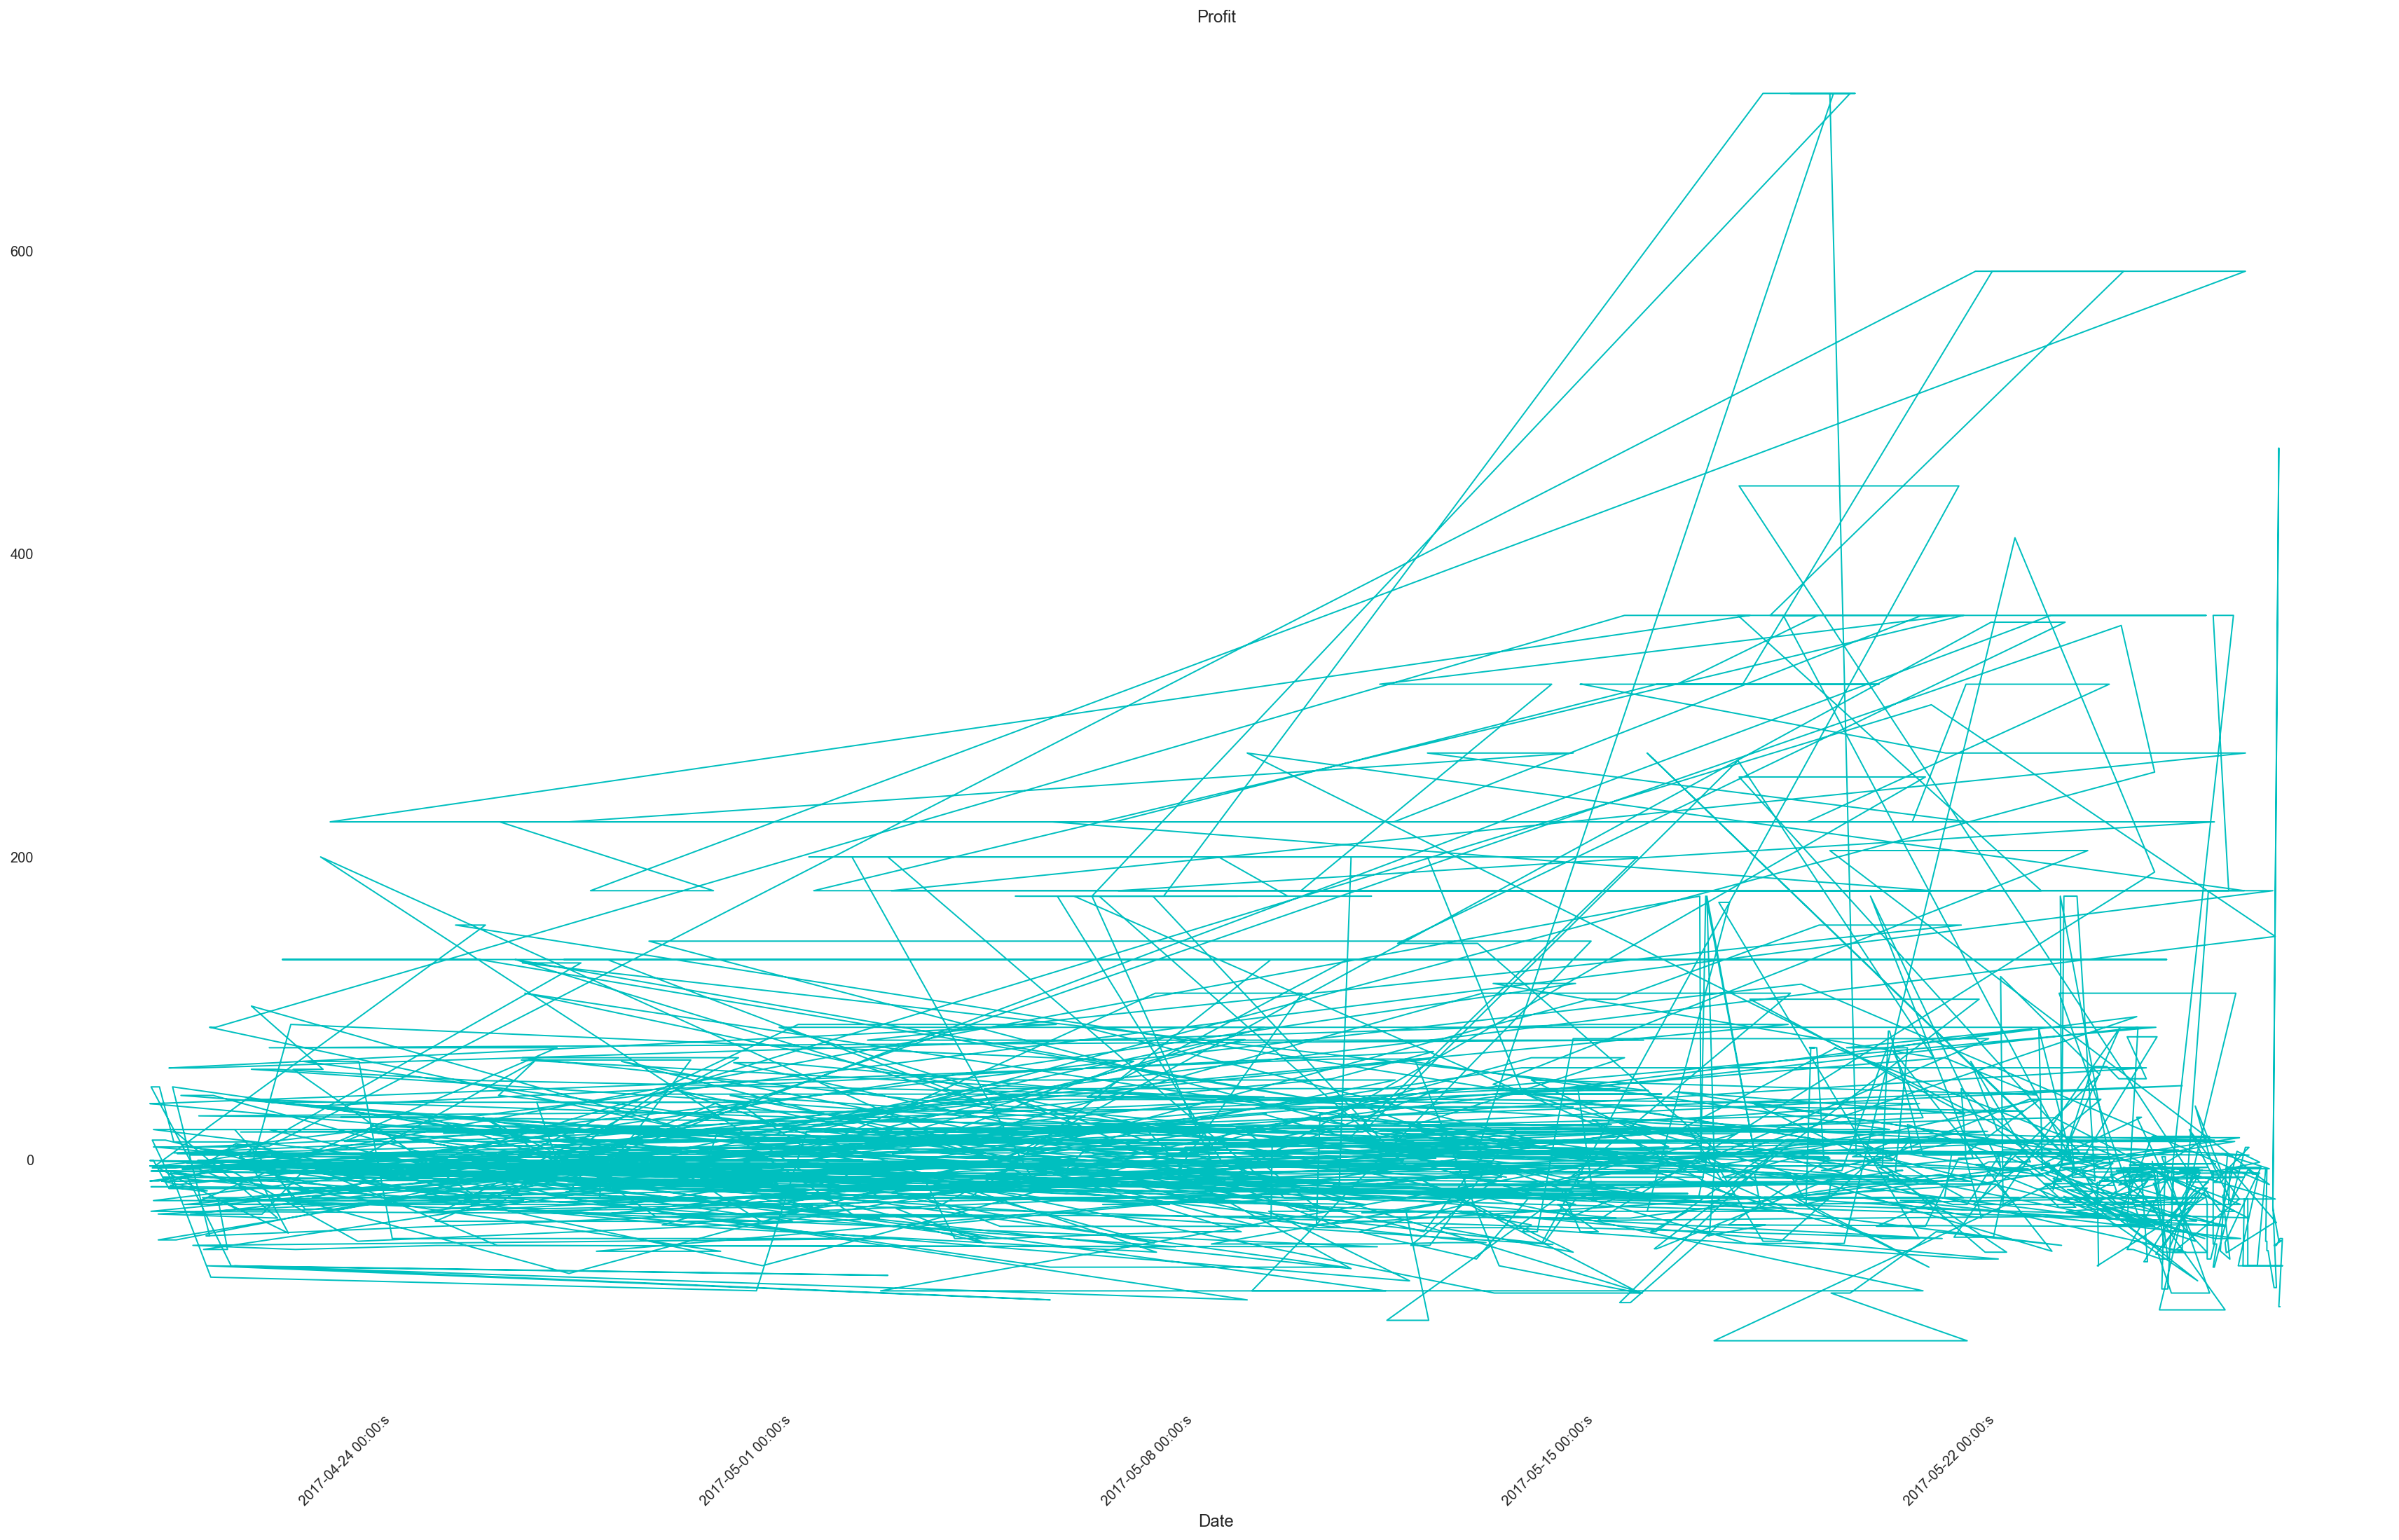

In [28]:
# This ultimately doesn't tell us anything, but it looks neat!! (∪´>‿<`)

y = concert_cleaned.profit
t = concert_cleaned.date
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(1, 1, 1, facecolor='white')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%s'))

ax1.plot(t, y, 'c', linewidth=1)
plt.title('Profit')
plt.xlabel('Date', fontsize='large')
fig.autofmt_xdate(rotation=45)

# Min/Max by Date Ranges

# Suspicious Behavior: 🚔

In [24]:
suspicious = concert_cleaned[(concert_cleaned['listing_price'] < 1.00)]
this_suspicious = concert_cleaned[concert_cleaned['profit'] > 400]
oh_this_is_suspicious = concert_cleaned[(concert_cleaned['profit'] > 400) & \
                                        (concert_cleaned['zoneName'] == 'Pit')]

also_suspicious = concert_cleaned[(concert_cleaned['listing_price'] > 300) & 
                                  (concert_cleaned['zoneName'] == 'Lawn GA')]

totally_suspicious = pd.concat([suspicious, this_suspicious, \
                                oh_this_is_suspicious, also_suspicious], axis=0)

totally_suspicious.drop(['currentPrice', 'listingPrice', 'faceValue', 'score', 'value', \
                 'splitOption', 'splitVector', 'dirtyTicketInd', 'sectionName', \
                 'zoneId', 'sectionId', 'row'], axis=1, inplace=True)

printable_suspicious = totally_suspicious.dropna(subset=['age'])
printable_suspicious.sort_values(['profit', 'listingId'], inplace=True)
printable_suspicious.reset_index(drop=True, inplace=True)
printable_suspicious.columns = [['Listing ID', 'Quantity', 'Zone Name', 'Sold Price', \
                                 'Sale Price', 'Profit', 'Date', 'Day of Week', \
                                 'Age', 'Average Face Value']]
printable_suspicious   

,Listing ID,Quantity,Zone Name,Sold Price,Sale Price,Profit,Date,Day of Week,Age,Average Face Value
0,1256977137,2,Lawn GA,0.79,0.79,-94.289,2017-05-15 14:30:03,Monday,0.0,95
1,1249321603,2,Lawn GA,366.10,303.00,177.700,2017-05-20 20:30:02,Saturday,11.0,95
2,1249321606,2,Lawn GA,366.10,303.00,177.700,2017-05-22 18:30:03,Monday,16.0,95
3,1249321616,2,Lawn GA,366.10,303.00,177.700,2017-05-26 19:30:03,Friday,24.0,95
4,1249321619,2,Lawn GA,366.10,303.00,177.700,2017-04-29 14:30:03,Saturday,2.0,95
5,1249321624,2,Lawn GA,366.10,303.00,177.700,2017-05-26 07:30:02,Friday,24.0,95
6,1258897745,4,Lawn GA,366.10,303.00,177.700,2017-05-26 01:00:02,Friday,0.0,95
7,1249321604,2,Lawn GA,426.70,353.50,223.150,2017-05-22 07:30:02,Monday,16.0,95
8,1249321605,2,Lawn GA,426.70,353.50,223.150,2017-05-25 19:00:02,Thursday,17.0,95
9,1249321608,4,Lawn GA,426.70,353.50,223.150,2017-05-20 12:30:02,Saturday,27.0,95


In [25]:
sus_ind = totally_suspicious.index.values
concert_cleaned.drop(sus_ind, axis=0, inplace=True)
concert_cleaned.reset_index(drop=True, inplace=True)

## Our outliers could possibly be fradualent transactions.
<b>x4 General Admission listings sold for 888.00 / 1068 with fees.<br>
That is 534 dollars per ticket, for a ticket with face value of 95 dollars.<br>
There is an additional listing for .79.<br>
This are likely microcharges to test the activity of credit card accounts.</b><br>
<b>In comparison, here is a listing for two front row seats for 753.17 / 906.30 with fees.<br>
That comes to 453.15 per ticket for <i>front row seats</i>.</b>

In [26]:
not_suspicious = concert_cleaned[concert_cleaned['listing_price'] == 753.17]
not_suspicious.T

,12
currentPrice,"{u'currency': u'USD', u'amount': 906.3}"
dirtyTicketInd,False
faceValue,NaN
listingId,1240692766
listingPrice,"{u'currency': u'USD', u'amount': 753.17}"
quantity,2
row,1
score,0.0
sectionId,165506.0
sectionName,Pit Right


In [166]:
date_range_p = concert_cleaned[['date', 'age', 'listing_price', 'profit', 'current_price', 'value', 'listingId']]
date_range_p = date_range_p[date_range_p['age'] < max_age]

date_range_p.drop(['listingId', 'age'], axis=1, inplace=True)
date_range_p['date'] = date_range_p['date'].dt.date
date_range_p.sort_values('date', inplace=True)

date_range_p_min = date_range_p.pivot_table(index='date', aggfunc='min')
date_range_v_min = date_range_p_min[['current_price', 'value']]
date_range_p_min.drop(['current_price', 'value'], axis=1, inplace=True)
date_range_p_min.columns
date_range_p_min.columns = ['Minimum Sold Price', 'Minimum Profit']
date_range_v_min.columns = ['Minimum Sale Price', 'Maximum Value']

date_range_p_max = date_range_p.pivot_table(index='date', aggfunc='max')
date_range_v_max = date_range_p_max[['current_price', 'value']]
date_range_p_max.drop(['current_price', 'value'], axis=1, inplace=True)
date_range_p_max.columns = ['Maximum Sold Price', 'Maximum Profit']
date_range_v_max.columns = ['Maximum Sale Price', 'Minimum Value']

date_range_p_minmax = pd.concat([date_range_p_min, date_range_p_max], axis=1)
date_range_v_minmax = pd.concat([date_range_v_min, date_range_v_max], axis=1)

In [63]:
date_range_p_minmax[['Minimum Sold Price', 'Maximum Sold Price']].iplot(kind='area', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Concert Ticket Sold Price<br>by Listing Date', \
                   xTitle='Date', yTitle='Dollars')

In [64]:
date_range_p_minmax[['Minimum Profit', 'Maximum Profit']].iplot(kind='line', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Concert Ticket Profit<br>by Listing Date', \
                   xTitle='Date', yTitle='Dollars')

In [71]:
date_range_v_minmax[['Minimum Sale Price', 'Maximum Sale Price']].iplot(kind='area', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Concert Ticket Sale Price<br>by Listing Date', \
                   xTitle='Date', yTitle='Dollars')

In [73]:
date_range_v_minmax.loc[:,'Minimum Value'] *= -1
date_range_v_minmax.loc[:,'Maximum Value'] *= -1
date_range_v_minmax[['Maximum Value', 'Minimum Value']].iplot(kind='line', \
                   fill='True', theme='white', margin=(88,5), \
                   title='Concert Ticket Value<br>by Listing Date', \
                   xTitle='Date', yTitle='Value')

# Min/Max by Listing

In [74]:
listing_range_p = concert_cleaned[['listingId', 'age', 'listing_price', 'profit']]
listing_range_p = listing_range_p[listing_range_p['age'] < max_age]
listing_range_p.drop('age', axis=1, inplace=True)
listing_range_p.sort_values('listingId', inplace=True)

listing_range_p = listing_range_p.pivot_table(index='listingId')
listing_range_p.columns = ['Sold Price', 'Profit']
listing_range_p.T

listingId,1240684091,1240686322,1240687191,1240687600,1240687855,1240687992,1240692766,1240694097,1240699269,1240701170,...,1259184058,1259188521,1259197595,1259210962,1259222289,1259223517,1259227641,1259230282,1259238594,1259247254
Sold Price,239.990,219.0,435.0,159.0,192.240,169.510,645.570,170.0,110.0,150.0,...,99.0,118.0,211.130,184.0,144.0,242.50,218.250,115.0,220.0,170.0
Profit,-34.009,37.1,66.5,-16.9,13.016,-7.441,256.013,-7.0,4.0,-25.0,...,-5.9,-53.8,-59.983,-84.4,-30.4,-31.75,-53.575,-56.5,-52.0,-97.0


In [75]:
listing_range_p.iplot(kind='line', theme='white', margin=(88,5), \
                      title='Concert Ticket Sold Price and Profit<br>by Listing ID', \
                      xTitle='Sequential Listing ID', yTitle='Dollars')

# Min/Max Profit by Day of Week

In [76]:
day_of_week_p = concert_cleaned[['profit', 'day_of_week', 'age']]
day_of_week_p = day_of_week_p[day_of_week_p['age'] < max_age]
day_of_week_p.drop('age', axis=1, inplace=True)

day_of_week_p.sort_values('day_of_week', inplace=True)

day_of_week_min = day_of_week_p.pivot_table(index='day_of_week', aggfunc='min')
day_of_week_min.columns = ['Minimum Profit']

day_of_week_max = day_of_week_p.pivot_table(index='day_of_week', aggfunc='max')
day_of_week_max.columns = ['Maximum Profit']

day_of_week_minmax = pd.concat([day_of_week_min, day_of_week_max], axis=1)

day_of_week_minmax = day_of_week_minmax.T

ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
day_of_week_minmax = day_of_week_minmax[ordered_days]
day_of_week_minmax

day_of_week,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
Minimum Profit,-119.5,-92.5,-76.3,-85.300,-99.1,-106.0,-86.5
Maximum Profit,200.0,200.0,204.2,256.013,174.1,200.0,252.8


In [77]:
day_of_week_minmax.iplot(kind='box', \
                           theme='white', margin=(88,5), \
                           title='Concert Ticket Minimum and Maximum Profit<br>by Day of Week', \
                           xTitle='Day of Week', yTitle='Dollars')

# Evaluating Profit by Time of Day

In [78]:
bins = [-1, 6, 11, 17, 20, 25]
bin_names = ['Late Night', 'Morning', 'Afternoon', 'Evening', 'Night']

time_of_day_p_range = concert_cleaned[['profit', 'date', 'age']]
time_of_day_p_range['time_hour'] = time_of_day_p_range['date'].dt.hour
categories = pd.cut(time_of_day_p_range['time_hour'], bins, labels=bin_names)
time_of_day_p_range['time_of_day'] = pd.cut(time_of_day_p_range['time_hour'], bins, labels=bin_names)
time_of_day_p_range = time_of_day_p_range[time_of_day_p_range['age'] < max_age]
time_of_day_p_range.drop(['date', 'age', 'time_hour'], axis=1, inplace=True)

time_of_day_p_range.sort_values('time_of_day', inplace=True)

time_of_day_p_min = time_of_day_p_range.pivot_table(index='time_of_day', aggfunc='min')
time_of_day_p_min.columns = ['Minimum Profit']

time_of_day_p_max = time_of_day_p_range.pivot_table(index='time_of_day', aggfunc='max')
time_of_day_p_max.columns = ['Maximum Profit']

time_of_day_p_minmax = pd.concat([time_of_day_p_min, time_of_day_p_max], axis=1)

In [79]:
time_of_day_p_minmax = time_of_day_p_minmax.T

ordered_time = ['Morning', 'Afternoon', 'Evening', 'Night', 'Late Night']
time_of_day_p_minmax = time_of_day_p_minmax[ordered_time]
time_of_day_p_minmax

time_of_day,Morning,Afternoon,Evening,Night,Late Night
Minimum Profit,-119.5,-88.0,-88.000,-99.1,-106.0
Maximum Profit,174.1,204.2,256.013,174.1,200.0


In [81]:
time_of_day_p_minmax.iplot(kind='box', margin=(88,5), \
                             title='Concert Ticket Minimum and Maximum Profit<br>by Time of Day', \
                             theme='white', xTitle='Time of Day', yTitle='Dollars', mean=True)

# Evaluating by Auction Launch Date

In [82]:
first_range = concert_cleaned[['listingId', 'date', 'age', 'listing_price', 'profit', 'current_price', 'value']]
first_range = first_range[first_range['age'] < max_age]
first_range.drop('listingId', axis=1, inplace=True)
first_range.drop('age', axis=1, inplace=True)
first_range.reset_index(drop=True, inplace=True)

first_range['date'] = pd.to_datetime(first_range['date']).dt.date

first_range.sort_values('date', inplace=True)

first_mins = first_range.pivot_table(index='date', aggfunc='min')
first_mins.columns = ['Minimum Listing Price', 'Minimum Sold Price',
                      'Minimum Profit', 'Maximum Value']
first_maxs = first_range.pivot_table(index='date', aggfunc='max')
first_maxs.columns = ['Maximum Listing Price', 'Maximum Sold Price',
                      'Maximum Profit', 'Minimum Value']

first_listed_minmax = pd.concat([first_mins['Minimum Listing Price'], \
                                 first_maxs['Maximum Listing Price']], axis=0)
                        
first_sold_minmax = pd.concat([first_mins['Minimum Sold Price'], \
                               first_maxs['Maximum Sold Price']], axis=0)

first_collected = pd.concat([first_listed_minmax, first_sold_minmax], axis=1)

In [83]:
first_sold_minmax.sort_index(inplace=True)
first_collected.columns = ['Min/Max Sale Price', 'Min/Max Sold Price']

In [84]:
first_collected.iplot(kind='bar', barmode='group', margin=(88,5), \
                      title='Concert Ticket Minimum and Maximum<br>Sale Price / Sold Price by Date', \
                      theme='white', xTitle='Date', yTitle='Dollars')

# Evaluating Profit by Listing Hour

In [85]:
hour_range = concert_cleaned[['listingId', 'date', 'age', 'listing_price', 'current_price']]
hour_range = hour_range[hour_range['age'] < max_age]
hour_range.drop('listingId', axis=1, inplace=True)
hour_range.drop('age', axis=1, inplace=True)
hour_range.reset_index(drop=True, inplace=True)

hour_range['hour'] = hour_range['date'].dt.hour
hour_range.drop('date', axis=1, inplace=True)
hour_range.sort_values('hour', inplace=True)

hour_mins = hour_range.pivot_table(index='hour', aggfunc='min')
hour_mins.columns = ['Minimum Listing Price', 'Minimum Sold Price']
hour_maxs = hour_range.pivot_table(index='hour', aggfunc='max')
hour_maxs.columns = ['Maximum Listing Price', 'Maximum Sold Price']

hour_range_final = pd.concat([hour_mins, hour_maxs], axis=1)
hour_range_final.T

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Minimum Listing Price,114.09,122.49,110.5,106.9,116.5,118.9,109.3,122.5,122.5,120.1,...,122.5,110.5,116.50,98.5,121.30,109.30,110.49,109.3,109.30,97.90
Minimum Sold Price,92.99,99.99,90.0,87.0,95.0,97.0,89.0,100.0,100.0,98.0,...,100.0,90.0,95.00,80.0,99.00,89.00,89.99,89.0,89.00,79.50
Maximum Listing Price,460.30,425.74,524.5,393.7,362.5,482.5,482.5,350.5,662.5,542.5,...,708.1,591.1,577.24,482.5,777.18,544.12,632.50,525.7,496.84,453.64
Maximum Sold Price,381.50,352.70,435.0,326.0,300.0,400.0,400.0,290.0,550.0,450.0,...,588.0,490.5,478.95,400.0,645.57,451.35,525.00,436.0,411.95,375.95


In [86]:
hour_range_final.iplot(kind='line', filename='profit_by_listing_hour', margin=(88,5), \
                 title='Concert Ticket Minimum / Maximum Sale Price and Sold Price<br>by Hour of Day', \
                 theme='white', xTitle='Listing Hour', yTitle='Dollars')

# Evaluating Profit by Zone

In [52]:
# ZoneID 28310 = zoneName Pit        - avg face value: $323 | mean listing price: $347
# ZoneID 28311 = zoneName Lower      - avg face value: $250 | mean listing price: $288 
# ZoneID 28312 = zoneName Upper      - avg face value: $159 | mean listing price: $182
# ZoneID 28313 = zoneName Lawn GA    - avg face value: $99 | mean listing price: $184
# ZoneID 252988 = zoneName SRO

In [267]:
zone_range_p = concert_cleaned[['zoneName', 'age', 'profit', 'value']]
zone_range_p = zone_range_p[zone_range_p['age'] < max_age]
zone_range_p.drop('age', axis=1, inplace=True)

zone_range_p_min = zone_range_p.pivot_table(index='zoneName', aggfunc='min')
zone_range_p_min.columns = ['Minimum Profit', 'Maximum Value']
zone_range_v_min = zone_range_p_min[['Maximum Value']]
zone_range_p_min.drop('Maximum Value', axis=1, inplace=True)

zone_range_p_max = zone_range_p.pivot_table(index='zoneName', aggfunc='max')
zone_range_p_max.columns = ['Maximum Profit', 'Minimum Value']
zone_range_v_max = zone_range_p_max['Minimum Value']
zone_range_p_max.drop('Minimum Value', axis=1, inplace=True)

zone_range_p_minmax = pd.concat([zone_range_p_min, zone_range_p_max], axis=1)
zone_range_v_minmax = pd.concat([zone_range_v_min, zone_range_v_max], axis=1)

In [268]:
concert_cleaned.groupby('zoneName')['profit'].max()

zoneName
Lawn GA    174.100
Lower      155.000
Pit        352.853
Upper      200.000
Name: profit, dtype: float64

In [269]:
zone_range_profit_minmax = zone_range_p_minmax[['Minimum Profit', 'Maximum Profit']]
zone_range_profit_minmax = zone_range_profit_minmax.T

ordered_zones = ['Lawn GA', 'Upper', 'Lower', 'Pit']
zone_range_profit_minmax = zone_range_profit_minmax[ordered_zones]

In [272]:
zone_range_profit_minmax.iplot(kind='box', theme='white', \
                    margin=(88,5), \
                    title='Concert Ticket Minimum / Maximum Profit by Zone', \
                    xTitle='Zone', yTitle='Dollars')

In [273]:
zone_range_v_minmax = zone_range_v_minmax.T
zone_range_v_minmax = zone_range_v_minmax[ordered_zones]
zone_range_v_minmax = zone_range_v_minmax.T

zone_range_v_minmax.loc[:,'Minimum Value'] *= -1
zone_range_v_minmax.loc[:,'Maximum Value'] *= -1

zone_range_v_minmax[['Minimum Value', 'Maximum Value']].iplot(kind='bar',  \
                    margin=(88,5), \
                    theme='white', title='Concert Ticket Mean Average Value by Zone', \
                    xTitle='Zone', yTitle='Value')

# What is the mean average listing price / sale price and profit / value by zone for tickets sold within the first / two / five / ten days from listing?

In [181]:
oned_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
oned_zone_range_min = oned_zone_range_min[oned_zone_range_min['age'] < 2]
oned_zone_range_min.drop('age', axis=1, inplace=True)       
                                
oned_zone_range_min = oned_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

oned_zone_range_min.T

zoneName,Lawn GA,Lower,Pit,Upper
current_price,97.9,176.5,303.7,98.5


In [182]:
oned_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
oned_zone_range_p = oned_zone_range_p[oned_zone_range_p['age'] < 2]
oned_zone_range_p.drop('age', axis=1, inplace=True)

oned_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
oned_zone_range_v = oned_zone_range_v[oned_zone_range_v['age'] < 2]
oned_zone_range_v.drop('age', axis=1, inplace=True)

oned_zone_range_v = oned_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

oned_zone_range_p = oned_zone_range_p.groupby('zoneName').mean()
oned_zone_range_p['volume'] = oned_zone_range_v['current_price']
oned_zone_range_p.drop('value', axis=1, inplace=True)
oned_zone_range_p['minimum_price'] = oned_zone_range_min['current_price']

In [183]:
oned_zone_range_p = oned_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [184]:
oned_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [185]:
oned_zone_range_p = oned_zone_range_p.T
oned_zone_range_p = oned_zone_range_p[ordered_zones]
oned_zone_range_p = oned_zone_range_p.T

In [187]:
oned_zone_range_p.iplot(kind='bar', barmode='group', theme='white', \
                   title='Concert Ticket Sale Price / Purchase Behavior Within The First Day', \
                   xTitle='Zone', yTitle='Dollars / Total')

In [188]:
twoed_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
twoed_zone_range_min = twoed_zone_range_min[twoed_zone_range_min['age'] < 3]
twoed_zone_range_min.drop('age', axis=1, inplace=True)        
                                
twoed_zone_range_min = twoed_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

twoed_zone_range_min.T

zoneName,Lawn GA,Lower,Pit,Upper
current_price,97.9,176.5,303.7,98.5


In [189]:
twoed_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
twoed_zone_range_p = twoed_zone_range_p[twoed_zone_range_p['age'] < 3]
twoed_zone_range_p.drop('age', axis=1, inplace=True)

twoed_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
twoed_zone_range_v = twoed_zone_range_v[twoed_zone_range_v['age'] < 3]
twoed_zone_range_v.drop('age', axis=1, inplace=True)

twoed_zone_range_v = twoed_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

twoed_zone_range_p = twoed_zone_range_p.groupby('zoneName').mean()

twoed_zone_range_p['volume'] = twoed_zone_range_v['current_price']
twoed_zone_range_p.drop('value', axis=1, inplace=True)
twoed_zone_range_p['minimum_price'] = twoed_zone_range_min['current_price']

In [190]:
twoed_zone_range_p = twoed_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [191]:
twoed_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [192]:
fived_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
fived_zone_range_min = fived_zone_range_min[fived_zone_range_min['age'] < 6]
fived_zone_range_min.drop('age', axis=1, inplace=True)       
                                
fived_zone_range_min = fived_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

fived_zone_range_min.T

zoneName,Lawn GA,Lower,Pit,Upper
current_price,97.9,176.5,303.7,98.5


In [193]:
fived_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
fived_zone_range_p = fived_zone_range_p[fived_zone_range_p['age'] < 6]
fived_zone_range_p.drop('age', axis=1, inplace=True)

fived_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
fived_zone_range_v = fived_zone_range_v[fived_zone_range_v['age'] < 6]
fived_zone_range_v.drop('age', axis=1, inplace=True)
fived_zone_range_v = fived_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

fived_zone_range_p = fived_zone_range_p.groupby('zoneName').mean()

fived_zone_range_p['volume'] = fived_zone_range_v['current_price']
fived_zone_range_p.drop('value', axis=1, inplace=True)
fived_zone_range_p['minimum_price'] = fived_zone_range_min['current_price']

In [194]:
fived_zone_range_p = fived_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [195]:
fived_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [196]:
fived_zone_range_p = fived_zone_range_p.T
fived_zone_range_p = fived_zone_range_p[ordered_zones]
fived_zone_range_p = fived_zone_range_p.T

In [118]:
fived_zone_range_p.iplot(kind='bar', barmode='group', theme='white', \
                   title='Concert Ticket Sale Price / Purchase Behavior Within Five Days', \
                   xTitle='Zone', yTitle='Dollars / Total')

In [197]:
tend_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
tend_zone_range_min = tend_zone_range_min[tend_zone_range_min['age'] < 11]
tend_zone_range_min.drop('age', axis=1, inplace=True)       
                                
tend_zone_range_min = tend_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

zoneName,Lawn GA,Lower,Pit,Upper
current_price,97.9,176.5,303.7,98.5


In [198]:
tend_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
tend_zone_range_p = tend_zone_range_p[tend_zone_range_p['age'] < 11]
tend_zone_range_p.drop('age', axis=1, inplace=True)

tend_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
tend_zone_range_v = tend_zone_range_v[tend_zone_range_v['age'] < 11]
tend_zone_range_v.drop('age', axis=1, inplace=True)
tend_zone_range_v = tend_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

tend_zone_range_p = tend_zone_range_p.groupby('zoneName').mean()
tend_zone_range_p['volume'] = tend_zone_range_v['current_price']
tend_zone_range_p.drop('value', axis=1, inplace=True)
tend_zone_range_p['minimum_price'] = tend_zone_range_min['current_price']

In [199]:
tend_zone_range_p = tend_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [200]:
tend_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [201]:
twent_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
twent_zone_range_min = twent_zone_range_min[twent_zone_range_min['age'] < 21]
twent_zone_range_min.drop('age', axis=1, inplace=True)     
                            
twent_zone_range_min = twent_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

zoneName,Lawn GA,Lower,Pit,Upper
current_price,97.9,176.5,303.7,98.5


In [202]:
twent_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
twent_zone_range_p = twent_zone_range_p[twent_zone_range_p['age'] < 21]
twent_zone_range_p.drop('age', axis=1, inplace=True)

twent_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
twent_zone_range_v = twent_zone_range_v[twent_zone_range_v['age'] < 21]
twent_zone_range_v.drop('age', axis=1, inplace=True)
twent_zone_range_v = twent_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

twent_zone_range_p = twent_zone_range_p.groupby('zoneName').mean()
twent_zone_range_p['volume'] = twent_zone_range_v['current_price']
twent_zone_range_p.drop('value', axis=1, inplace=True)
twent_zone_range_p['minimum_price'] = twent_zone_range_min['current_price']

In [203]:
twent_zone_range_p = twent_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [204]:
twent_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [205]:
twent_zone_range_r = pd.DataFrame()

twent_zone_range_r['Total Revenue'] = twent_zone_range_p['Average Profit'] * \
                                      twent_zone_range_p['Total Quantity Sold']

In [206]:
thirt_zone_range_min = concert_cleaned[['zoneName', 'age', 'current_price']]
thirt_zone_range_min = thirt_zone_range_min[thirt_zone_range_min['age'] < 31]
thirt_zone_range_min.drop('age', axis=1, inplace=True)     
                            
thirt_zone_range_min = thirt_zone_range_min.pivot_table(index='zoneName', aggfunc='min')

zoneName,Lawn GA,Lower,Pit,Upper
current_price,97.9,176.5,303.7,98.5


In [207]:
thirt_zone_range_p = concert_cleaned[['zoneName', 'age', 'listing_price', 'profit', 'current_price', 'value']]
thirt_zone_range_p = thirt_zone_range_p[thirt_zone_range_p['age'] < 31]
thirt_zone_range_p.drop('age', axis=1, inplace=True)

thirt_zone_range_v = concert_cleaned[['zoneName', 'current_price', 'age']]
thirt_zone_range_v = thirt_zone_range_v[thirt_zone_range_v['age'] < 31]
thirt_zone_range_v.drop('age', axis=1, inplace=True)
thirt_zone_range_v = thirt_zone_range_v.pivot_table(index='zoneName', aggfunc='count')

thirt_zone_range_p = thirt_zone_range_p.groupby('zoneName').mean()
thirt_zone_range_p['volume'] = thirt_zone_range_v['current_price']
thirt_zone_range_p.drop('value', axis=1, inplace=True)
thirt_zone_range_p['minimum_price'] = thirt_zone_range_min['current_price']

In [208]:
thirt_zone_range_p = thirt_zone_range_p[['current_price', 'listing_price', \
                                        'minimum_price', 'profit', 'volume']]

In [209]:
thirt_zone_range_p.columns = ['Average Sale Price', 'Average Sold Price', 'Minimum Sale Price', \
                             'Average Profit', 'Total Quantity Sold']

In [210]:
thirt_zone_range_p = thirt_zone_range_p.T
thirt_zone_range_p = thirt_zone_range_p[ordered_zones]
thirt_zone_range_p = thirt_zone_range_p.T

In [211]:
thirt_zone_range_r = pd.DataFrame()

thirt_zone_range_r['Total Revenue'] = thirt_zone_range_p['Average Profit'] * \
                                      thirt_zone_range_p['Total Quantity Sold']

In [134]:
thirt_zone_range_p.iplot(kind='bar', barmode='group', theme='white', \
                   margin=(88,5), \
                   title='Concert Ticket Purchase Behavior Within Thirty Days', \
                   xTitle='Zone', yTitle='Dollars / Total')

In [212]:
thirt_zone_range_r.T.iplot(kind='barh', theme='white', margin=(88,5), \
                           xTitle='Dollars',
                           title='Concert Tickets Total Revenue Over 30 Days<br>by Zone')

# What is the volume of tickets sold by zone within the first / two / five / ten days from listing?

In [478]:
one_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
one_v_zone_range = one_v_zone_range[one_v_zone_range['age'] < 2]
one_v_zone_range.drop('age', axis=1, inplace=True)
one_v_zone_range = one_v_zone_range.groupby('zoneName').count()

one_v_zone_range.columns = ['Count']
one_v_zone_range.T

zoneName,Lawn GA,Lower,Pit,Upper
Count,127,63,18,201


In [479]:
two_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
two_v_zone_range = two_v_zone_range[two_v_zone_range['age'] < 3]
two_v_zone_range.drop('age', axis=1, inplace=True)
two_v_zone_range = two_v_zone_range.groupby('zoneName').count()

two_v_zone_range.columns = ['Count']
two_v_zone_range.T

zoneName,Lawn GA,Lower,Pit,Upper
Count,143,78,23,220


In [480]:
five_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
five_v_zone_range = five_v_zone_range[five_v_zone_range['age'] < 6]
five_v_zone_range.drop('age', axis=1, inplace=True)
five_v_zone_range = five_v_zone_range.groupby('zoneName').count()

five_v_zone_range.columns = ['Count']
five_v_zone_range.T

zoneName,Lawn GA,Lower,Pit,Upper
Count,164,87,36,262


In [481]:
ten_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
ten_v_zone_range = ten_v_zone_range[ten_v_zone_range['age'] < 11]
ten_v_zone_range.drop('age', axis=1, inplace=True)
ten_v_zone_range = ten_v_zone_range.groupby('zoneName').count()

ten_v_zone_range.columns = ['Count']
ten_v_zone_range.T

zoneName,Lawn GA,Lower,Pit,Upper
Count,171,99,49,293


In [482]:
twenty_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
twenty_v_zone_range = twenty_v_zone_range[twenty_v_zone_range['age'] < 21]
twenty_v_zone_range.drop('age', axis=1, inplace=True)
twenty_v_zone_range = twenty_v_zone_range.groupby('zoneName').count()

twenty_v_zone_range.columns = ['Count']
twenty_v_zone_range.T

zoneName,Lawn GA,Lower,Pit,Upper
Count,185,110,54,310


In [484]:
thirty_v_zone_range = concert_cleaned[['zoneName', 'age', 'profit']]
thirty_v_zone_range = thirty_v_zone_range[thirty_v_zone_range['age'] < 31]
thirty_v_zone_range.drop('age', axis=1, inplace=True)
thirty_v_zone_range = thirty_v_zone_range.groupby('zoneName').count()

thirty_v_zone_range.columns = ['Count']
thirty_v_zone_range.T

zoneName,Lawn GA,Lower,Pit,Upper
Count,195,113,54,313


In [485]:
one_two_five_ten = pd.DataFrame()
one_two_five_ten['One Day'] = one_v_zone_range['Count']
one_two_five_ten['Two Days'] = two_v_zone_range['Count']
one_two_five_ten['Five Days'] = five_v_zone_range['Count']
one_two_five_ten['Ten Days'] = ten_v_zone_range['Count']
one_two_five_ten['Twenty Days'] = twenty_v_zone_range['Count']
one_two_five_ten['Thirty Days'] = thirty_v_zone_range['Count']
one_two_five_ten.T

zoneName,Lawn GA,Lower,Pit,Upper
One Day,127,63,18,201
Two Days,143,78,23,220
Five Days,164,87,36,262
Ten Days,171,99,49,293
Twenty Days,185,110,54,310
Thirty Days,195,113,54,313


In [489]:
one_two_five_ten = one_two_five_ten.T
one_two_five_ten = one_two_five_ten[ordered_zones]
one_two_five_ten = one_two_five_ten.T

In [737]:
one_two_five_ten.iplot(kind='bar', theme='white', \
                       title='Total Number of Concert Tickets Sold<br>by Zone', \
                       margin=(88,5), \
                       xTitle='Zone', yTitle='Number Sold')

# Profit is our target. 

## The more accurately we can predict profit, the better we can maximize the potential for continuous profitability in 'flipping tickets'. 🥞

# Correlations 👯

In [65]:
concert_keep = ['zoneName', 'quantity','splitOption','sectionId','zoneId','listing_price', \
                'current_price','day_of_week', 'profit', 'value', 'age']
concert_analysis = concert_cleaned[concert_keep]
concert_analysis['quantity'] = pd.to_numeric(concert_analysis['quantity']).astype(float).copy()
concert_analysis['splitOption'] = pd.to_numeric(concert_analysis['splitOption']).astype(float).copy()
concert_analysis['sectionId'] = pd.to_numeric(concert_analysis['sectionId']).astype(float).copy()
concert_analysis['zoneId'] = pd.to_numeric(concert_analysis['zoneId']).astype(float).copy()
concert_dummies = pd.get_dummies(concert_analysis[['day_of_week', 'zoneName']]).astype(float)
concert_analysis.drop(['day_of_week', 'zoneName'], axis=1, inplace=True)
concert_analysis = concert_analysis.join(concert_dummies)

In [66]:
corr = concert_analysis.corr()

corr.iplot(kind='heatmap', title='Concert Ticket Correlation Matrix', theme='white', margin=(155,5))

In [83]:
corr2 = concert_analysis[['sectionId', 'zoneId']].corr()

corr2.iplot(kind='heatmap', title='Zone ID and Section ID Correlation Matrix', theme='white', margin=(155,5))

# Model Setup 💃🏻💻

In [187]:
concert_keep = ['quantity','zoneId','listing_price', \
                'day_of_week', 'age', 'profit']
concert_analysis = concert_cleaned[concert_keep]
concert_analysis.dropna(subset=['age'], inplace=True)
concert_analysis['quantity'] = pd.to_numeric(concert_analysis['quantity']).astype(float).copy()
concert_analysis['zoneId'] = pd.to_numeric(concert_analysis['zoneId']).astype(float).copy()
concert_dummies = pd.get_dummies(concert_analysis['day_of_week']).astype(float)
concert_analysis.drop('day_of_week', axis=1, inplace=True)
concert_analysis = concert_analysis.join(concert_dummies)

In [171]:
X = concert_analysis
y = concert_analysis['profit']
X.drop('profit', axis=1, inplace=True)

In [172]:
# break up the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [173]:
print 'X train shape: ', X_train.shape
print 'y train shape: ', y_train.shape
print 'X test shape', X_test.shape
print 'y test shape: ', y_test.shape

X train shape:  (346, 11)
y train shape:  (346,)
X test shape (346, 11)
y test shape:  (346,)


# Let's try all the things! 😸
# Target: Profit

## Identifying Coefficients with LassoCV

In [174]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [175]:
model_lasso = LassoCV(n_alphas=100, selection='random', max_iter=15000).fit(X_train, y_train)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 13.923908331751786)
('Min: ', 11.832762486452753)


In [176]:
lasso_df = concert_analysis
l_coef = pd.Series(model_lasso.coef_, index = lasso_df.columns)
print("Lasso picked " + str(sum(l_coef != 0)) + " variables and eliminated the other " +  str(sum(l_coef == 0)) + " variables")

Lasso picked 2 variables and eliminated the other 9 variables


In [177]:
lasso_coef = pd.concat([l_coef.sort_values().head(10),
                        l_coef.sort_values().tail(10)])

lasso_coef.iplot(kind = "barh", theme='white', \
                 margin=(155,5), \
                 title='Coefficients in the Lasso Regression<br>Profit as Target')

## Not a lot of signal here...

## Identifying Coefficients with RidgeCV

In [178]:
model_ridge = RidgeCV(alphas=(0.01, 0.1, 1.0, 10, 100)).fit(X_train, y_train)
res = rmse_cv(model_ridge)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 5.999740268164099)
('Min: ', 5.7780772458759904)


In [179]:
ridge_df = concert_analysis
r_coef = pd.Series(model_ridge.coef_, index = ridge_df.columns)
print("Ridge picked " + str(sum(r_coef != 0)) + " variables and eliminated the other " +  str(sum(r_coef == 0)) + " variables")

Ridge picked 11 variables and eliminated the other 0 variables


In [180]:
ridge_coef = pd.concat([r_coef.sort_values().head(10),
                        r_coef.sort_values().tail(10)])

ridge_coef.iplot(kind = "barh", theme='white', \
                 margin=(155,5), \
                 title='Coefficients in the Ridge Regression<br>Profit as Target')

## Same here, but we also see that certain days of week and the sale price of the ticket having strength.

## Identifying Coefficients with ElasticNetCV

In [181]:
model_en = ElasticNetCV(n_alphas=100, alphas=(0.01, 0.1, 1.0, 10, 100, 250, 500, 750, 1000), \
                        max_iter=15000, cv=5, n_jobs=-1).fit(X_train, y_train)
res = rmse_cv(model_en)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 6.0189422255614939)
('Min: ', 5.6763466991164719)


In [182]:
en_df = concert_analysis
en_coef = pd.Series(model_en.coef_, index = en_df.columns)
print("ElasticNet picked " + str(sum(en_coef != 0)) + " variables and eliminated the other " +  str(sum(en_coef == 0)) + " variables")

ElasticNet picked 10 variables and eliminated the other 1 variables


In [183]:
elasn_coef = pd.concat([en_coef.sort_values().head(10),
                      en_coef.sort_values().tail(10)])

elasn_coef.iplot(kind = "barh", theme='white', 
                 margin=(155,5), \
                 title='Coefficients in the ElasticNet Regression<br>Profit as Target')

## The ElasticNet response shows that a few days of the week are suboptimal.
## For now, let's keep everything and try a Linear Regression.

In [189]:
lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True, n_jobs=-1)

lr.fit(X_train, y_train)

pred_lr_profit = pd.DataFrame()
pred_lr_profit['Predicted Profit'] = lr.predict(X_test)
scores = cross_val_score(lr, X_test, y_test, cv=5)

lr_profit_score = '5-Fold CV Mean Average: {percent:.2%}'.format(percent=scores.mean())
lr_profit_std = 'Standard Deviation: {percent:.2%}'.format(percent=scores.std() * 2)
lr_profit_r2 = 'R^2 score: {percent:.2%}'.format(percent=r2_score(y_test, lr.predict(X_test)))

print lr_profit_score
print lr_profit_std
print lr_profit_r2

5-Fold CV Mean Average: 99.69%
Standard Deviation: 0.11%
R^2 score: 99.71%


In [190]:
true_profit = pd.DataFrame(y_test.astype(float))
true_profit.columns = ['True Profit']
true_profit.reset_index(inplace=True, drop=True)

In [191]:
predicted_profit = pd.concat([pred_lr_profit, true_profit], axis=1)

In [192]:
predicted_profit.T

,0,1,2,3,4,5,6,7,8,9,...,336,337,338,339,340,341,342,343,344,345
Predicted Profit,-69.972596,0.014169,41.862683,-30.861309,40.611892,-38.929581,11.315718,6.051997,-27.788138,8.858233,...,-45.009088,33.518866,-44.18921,-22.785807,21.29028,-17.674786,-49.430812,11.343815,314.275296,25.863068
True Profit,-65.608000,-7.108000,48.161000,-25.000000,46.865000,-34.000000,17.192000,11.801000,-20.500000,3.982000,...,-39.400000,39.800000,-38.50000,-16.000000,28.10000,-11.500000,-43.837000,5.800000,314.050000,20.000000


In [131]:
predicted_profit.iplot(title='Linear Regression<br>Profit as Target', \
                       margin=(88,5), \
                       theme='white', xTitle=lr_profit_score, yTitle=lr_profit_std)

## Hyperparameter Optimization

In [55]:
# LR_parameters = {'copy_X':(True, False),
#                  'fit_intercept':(True, False),
#                  'normalize':(True, False)
#                 }

# RFR_parameters = {'n_estimators':(5,10,15,25,35,50),
#                   'criterion':('mae', 'mse'),
#                   'bootstrap':(True, False),
# #                'oob_score':(True, False),
#                   'warm_start':(True,False)
#                   }

# ABR_parameters = {'n_estimators':(10,15,20,50,75,100),
#                   'learning_rate':(1,2,3,4,5),
#                   'loss':('linear','square','exponential')
#                  }

# BR_parameters = {'n_iter':(5,10,15,25,50,75,100),
#                  'compute_score':(True,False),
#                  'fit_intercept':(True,False),
#                  'normalize':(True,False),
#                  'copy_X':(True,False)
#                 }

# KNN_parameters = {'n_neighbors':(2,3,4,5,6,7,8),
#                   'weights':('uniform', 'distance'),
#                   'algorithm':('ball_tree', 'kd_tree', 'brute'),
#                   'metric':('minkowski', 'euclidean', 'manhattan', 'chebyshev')
#                  }

# only_the_best = GridSearchCV(KNeighborsRegressor(), parameters, verbose=1, cv=5, n_jobs=-1)
# only_the_best.fit(X_train, y_train)
# only_the_best.best_estimator_ 

## Scoring with Cross Validation

In [193]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

cross_p_mean = []
cross_p_std = []
cross_p_r2 = []
cross_p_time = []

cross_p_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(X_train, y_train)
    cross_p_predictions[other_rgs] = other_rgs.predict(X_test)
    
    
    start = timer()
    scores = cross_val_score(other_rgs, X_test, y_test, cv=5)
    cross_p_mean.append(scores.mean())
    cross_p_std.append(scores.std() * 2)
    cross_p_r2.append(r2_score(y_test, other_rgs.predict(X_test)))
    end = timer()
    cross_p_time.append(end-start)
    print '\n'

print '\n'
print '---\n5-Fold Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(cross_p_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(cross_p_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(cross_p_r2))
print 'Time: ', end-start

print '\n'
    
print cross_p_mean, '\n'
print cross_p_std, '\n'
print cross_p_r2, '\n'
print cross_p_time, '\n'

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)




---
5-Fold Cross Validation Scores:
Mean Average: 93.30%
Standard Deviati

In [194]:
cross_p_col_len = len(cross_p_predictions.columns)
cross_p_predictions.columns = np.arange(0, cross_p_col_len, 1)
cross_p_predictions

,0,1,2,3,4
0,-0.504500,-69.964680,-65.21236,-29.645905,-69.972596
1,-7.625000,0.031369,-7.18000,-28.442959,0.014169
2,17.806884,41.861231,43.18544,60.282480,41.862683
3,-25.900000,-30.858797,-24.98632,-2.823569,-30.861309
4,45.154430,40.612947,43.92812,65.419181,40.611892
5,-34.450000,-38.924360,-33.71200,-24.176412,-38.929581
6,17.192000,11.315973,15.71060,29.141983,11.315718
7,11.558000,6.053452,10.73900,29.141983,6.051997
8,-20.542429,-27.776590,-20.72680,-3.722681,-27.788138
9,4.000000,8.842601,4.03564,-18.740675,8.858233


## Scoring with KFolds

In [195]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

kfold_p_mean = []
kfold_p_std = []
kfold_p_r2 = []
kfold_p_time = []

kfold_p_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(X_train, y_train)
    kfold_p_predictions[other_rgs] = other_rgs.predict(X_test)
    
    cv = KFold(n_splits=3, shuffle=False, random_state=0)
    
    start = timer()
    scores = cross_val_score(other_rgs, X_test, y_test, cv=cv)
    kfold_p_mean.append(scores.mean())
    kfold_p_std.append(scores.std() * 2)
    kfold_p_r2.append(r2_score(y_test, other_rgs.predict(X_test)))
    end = timer()
    kfold_p_time.append(end-start)
    print '\n'

print '\n'
print '---\nKFold Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(kfold_p_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(kfold_p_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(kfold_p_r2))
print 'Time: ', end-start

print '\n'
    
print kfold_p_mean, '\n'
print kfold_p_std, '\n'
print kfold_p_r2, '\n'
print kfold_p_time, '\n'

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)




---
KFold Cross Validation Scores:
Mean Average: 92.48%
Standard Deviatio

In [196]:
kfold_p_col_len = len(kfold_p_predictions.columns)
kfold_p_predictions.columns = np.arange(0, kfold_p_col_len, 1)
kfold_p_predictions

,0,1,2,3,4
0,-0.504500,-69.964680,-66.04000,-22.659136,-69.972596
1,-7.625000,0.031369,-7.86400,-20.752894,0.014169
2,17.806884,41.861231,47.03168,49.224158,41.862683
3,-25.900000,-30.858797,-24.91936,12.629197,-30.861309
4,45.154430,40.612947,45.14852,61.637857,40.611892
5,-34.450000,-38.924360,-34.16200,-20.400931,-38.929581
6,17.192000,11.315973,16.86008,29.255556,11.315718
7,11.558000,6.053452,11.22392,30.462054,6.051997
8,-20.542429,-27.776590,-20.68000,10.438400,-27.788138
9,4.000000,8.842601,3.99352,-24.675929,8.858233


## Scoring by Shuffle Split

In [197]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

shuff_p_mean = []
shuff_p_std = []
shuff_p_r2 = []
shuff_p_time = []

shuff_p_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(X_train, y_train)
    shuff_p_predictions[other_rgs] = other_rgs.predict(X_test)
    
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=None)
    
    start = timer()
    scores = cross_val_score(other_rgs, X_test, y_test, cv=cv)
    shuff_p_mean.append(scores.mean())
    shuff_p_std.append(scores.std() * 2)
    shuff_p_r2.append(r2_score(y_test, other_rgs.predict(X_test)))
    end = timer()
    shuff_p_time.append(end-start)
    print '\n'

print '\n'
print '---\nShuffle Split Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(shuff_p_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(shuff_p_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(shuff_p_r2))
print 'Time: ', end-start

print '\n'
    
print shuff_p_mean, '\n'
print shuff_p_std, '\n'
print shuff_p_r2, '\n'
print shuff_p_time, '\n'

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)




---
Shuffle Split Cross Validation Scores:
Mean Average: 92.79%
Standard 

In [198]:
shuff_p_col_len = len(shuff_p_predictions.columns)
shuff_p_predictions.columns = np.arange(0, shuff_p_col_len, 1)
shuff_p_predictions

,0,1,2,3,4
0,-0.504500,-69.964680,-65.17600,-31.423028,-69.972596
1,-7.625000,0.031369,-7.93240,-15.490308,0.014169
2,17.806884,41.861231,48.34424,45.286892,41.862683
3,-25.900000,-30.858797,-24.97408,-5.218440,-30.861309
4,45.154430,40.612947,46.20836,52.579106,40.611892
5,-34.450000,-38.924360,-33.78400,-23.597863,-38.929581
6,17.192000,11.315973,17.04980,33.251908,11.315718
7,11.558000,6.053452,11.44136,33.251908,6.051997
8,-20.542429,-27.776590,-20.57596,-5.218440,-27.788138
9,4.000000,8.842601,4.03240,-19.397231,8.858233


# Chart it Out 📈

In [199]:
all_profit_mean_scores = pd.DataFrame()
all_profit_std_scores = pd.DataFrame()
all_profit_time_scores = pd.DataFrame()
all_profit_r2_scores = pd.DataFrame()

all_profit_mean_scores['5-Fold CV'] = cross_p_mean
all_profit_std_scores['5-Fold CV'] = cross_p_std
all_profit_time_scores['5-Fold CV'] = cross_p_time
all_profit_r2_scores['5-Fold CV'] = cross_p_r2

all_profit_mean_scores['KFold'] = kfold_p_mean
all_profit_std_scores['KFold'] = kfold_p_std
all_profit_time_scores['KFold'] = kfold_p_time
all_profit_r2_scores['KFold'] = kfold_p_r2

all_profit_mean_scores['Shuffle Split'] = shuff_p_mean
all_profit_std_scores['Shuffle Split'] = shuff_p_std
all_profit_time_scores['Shuffle Split'] = shuff_p_time
all_profit_r2_scores['Shuffle Split'] = shuff_p_r2

all_profit_mean_scores = all_profit_mean_scores.T
all_profit_std_scores = all_profit_std_scores.T
all_profit_time_scores = all_profit_time_scores.T
all_profit_r2_scores = all_profit_r2_scores.T

In [200]:
all_profit_mean_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                  'Linear']
all_profit_std_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                 'Linear']
all_profit_r2_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_profit_time_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                  'Linear']

In [201]:
all_profit_mean_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.754538,0.996880,0.975132,0.941425,0.996879
KFold,0.743313,0.997047,0.957094,0.929278,0.997045
Shuffle Split,0.789407,0.996169,0.943142,0.914048,0.996550


In [202]:
all_profit_std_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.275529,0.001056,0.028767,0.039765,0.001052
KFold,0.128642,0.000582,0.055420,0.006829,0.000594
Shuffle Split,0.358368,0.004834,0.146031,0.088053,0.003423


In [203]:
all_profit_r2_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.794004,0.997135,0.979574,0.937265,0.997137
KFold,0.794004,0.997135,0.982537,0.923866,0.997137
Shuffle Split,0.794004,0.997135,0.980064,0.942102,0.997137


In [204]:
all_profit_time_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.031970,0.037410,1.126500,1.775602,0.020659
KFold,0.023130,0.023283,0.861336,0.895847,0.012097
Shuffle Split,0.065371,0.068422,1.806819,2.979281,0.051026


In [68]:
all_profit_mean_scores.T.iplot(kind='barh', fill=True, theme='white', \
                               margin=(88,5), \
                               title='Concert Ticket Mean Average Accuracy Scores<br>Profit as Target')

In [69]:
all_profit_std_scores.T.iplot(kind='barh', theme='white', \
                              margin=(88,5), \
                              title="Concert Ticket Model Standard Deviation<br>Profit as Target")

In [70]:
all_profit_time_scores.iplot(kind='barh', margin=(88,5), \
                             title='Concert Ticket Model Completion Time<br>Profit as Target', \
                             theme='white', xTitle='Time in Seconds<br>Lower is Better')

In [71]:
all_profit_r2_scores.T.iplot(kind='barh', title='Concert Ticket Model R<sup>2</sup> Score<br>Profit as Target', \
                             margin=(88,5), \
                             theme='white')

# 💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲🙌💲

# Value is our target!

## The more accurately we can predict value, the greater likelihood for quick resale of desireable tickets. 📈

# Setup 💻

In [205]:
concert_keep = ['quantity','zoneId','current_price', \
                'day_of_week', 'value', 'age']
concert_analysis = concert_cleaned[concert_keep]
concert_analysis.dropna(subset=['age'], inplace=True)
concert_analysis['quantity'] = pd.to_numeric(concert_analysis['quantity']).astype(float).copy()
concert_analysis['zoneId'] = pd.to_numeric(concert_analysis['zoneId']).astype(float).copy()
concert_dummies = pd.get_dummies(concert_analysis['day_of_week']).astype(float)
concert_analysis.drop('day_of_week', axis=1, inplace=True)
concert_analysis = concert_analysis.join(concert_dummies)

In [206]:
Xv = concert_analysis
yv = concert_analysis['value']
Xv.drop('value', axis=1, inplace=True)

In [209]:
# break up the data into train and test
Xv_train, Xv_test, yv_train, yv_test = train_test_split(Xv, yv, test_size=0.5)

In [210]:
print 'Xv train shape: ', Xv_train.shape
print 'yv train shape: ', yv_train.shape
print 'Xv test shape', Xv_test.shape
print 'yv test shape: ', yv_test.shape

Xv train shape:  (346, 11)
yv train shape:  (346,)
Xv test shape (346, 11)
yv test shape:  (346,)


# Let's try all the things... again! 😸
# Target: Value

## Identifying Coefficients with LassoCV

In [211]:
model_lassov = LassoCV(n_alphas=100, selection='random', max_iter=15000).fit(Xv_train, yv_train)
res = rmse_cv(model_lassov)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 14.129396955450721)
('Min: ', 11.869341113949481)


In [212]:
lasso_dfv = concert_analysis
lv_coef = pd.Series(model_lassov.coef_, index = lasso_dfv.columns)
print("Lasso picked " + str(sum(lv_coef != 0)) + " variables and eliminated the other " +  str(sum(lv_coef == 0)) + " variables")

Lasso picked 3 variables and eliminated the other 8 variables


In [213]:
lassov_coef = pd.concat([lv_coef.sort_values().head(10),
                         lv_coef.sort_values().tail(10)])

lassov_coef.iplot(kind = "barh", theme='white', \
                  margin=(155,5), \
                  title='Coefficients in the Lasso Regression<br>Value as Target')

## Identifying Coefficients with RidgeCV

In [214]:
model_ridgev = RidgeCV(alphas=(0.01, 0.1, 1.0, 10, 100)).fit(Xv_train, yv_train)
res = rmse_cv(model_ridgev)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 5.999740268164099)
('Min: ', 5.7780772458759904)


In [82]:
ridgev_df = concert_analysis
rv_coef = pd.Series(model_ridgev.coef_, index = ridgev_df.columns)
print("Ridge picked " + str(sum(rv_coef != 0)) + " variables and eliminated the other " +  str(sum(rv_coef == 0)) + " variables")

Ridge picked 11 variables and eliminated the other 0 variables


In [83]:
ridgev_coef = pd.concat([rv_coef.sort_values().head(10),
                         rv_coef.sort_values().tail(10)])

ridgev_coef.iplot(kind = "barh", theme='white', \
                  margin=(155,5), \
                  title='Coefficients in the Ridge Regression<br>Value as Target')

## Identifying Coefficients with ElasticNetCV

In [84]:
model_env = ElasticNetCV(n_alphas=100, alphas=(0.01, 0.1, 1.0, 10, 100), \
                        max_iter=15000, cv=5, n_jobs=-1).fit(Xv_train, yv_train)
res = rmse_cv(model_env)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 5.9033863940278239)
('Min: ', 5.6980089824433717)


In [85]:
env_df = concert_analysis
env_coef = pd.Series(model_env.coef_, index = env_df.columns)
print("ElasticNet picked " + str(sum(env_coef != 0)) + " variables and eliminated the other " +  str(sum(env_coef == 0)) + " variables")

ElasticNet picked 4 variables and eliminated the other 7 variables


In [86]:
# Plotting the coefficients

elasnv_coef = pd.concat([env_coef.sort_values().head(10),
                        env_coef.sort_values().tail(10)])

elasnv_coef.iplot(kind = "barh", theme='white', \
                  margin=(155,5), \
                  title='Coefficients in the ElasticNet Regression<br>Value as Target')

## Again, the ElasticNet response shows me that a few days of the week are suboptimal.

# Linear Regression

In [87]:
lr = LinearRegression(copy_X=True, fit_intercept=True, normalize=True, n_jobs=-1)

lr.fit(Xv_train, yv_train)

pred_lr_value = pd.DataFrame()
pred_lr_value['Predicted Value'] = lr.predict(Xv_test)
scores = cross_val_score(lr, Xv_test, yv_test, cv=5)

lr_value_score = '5-Fold CV Mean Average: {percent:.2%}'.format(percent=scores.mean())
lr_value_std = 'Standard Deviation: {percent:.2%}'.format(percent=scores.std() * 2)
lr_value_r2 = 'R^2 score: {percent:.2%}'.format(percent=r2_score(yv_test, lr.predict(Xv_test)))

print lr_value_score
print lr_value_std
print lr_value_r2

5-Fold CV Mean Average: 84.15%
Standard Deviation: 8.60%
R^2 score: 85.06%


In [88]:
true_value = pd.DataFrame(yv_test.astype(float))
true_value.columns = ['True Value']
true_value.reset_index(inplace=True, drop=True)

In [89]:
predicted_value = pd.concat([pred_lr_value, true_value], axis=1)

In [90]:
predicted_value.T

,0,1,2,3,4,5,6,7,8,9,...,382,383,384,385,386,387,388,389,390,391
Predicted Value,-0.650403,0.721798,0.187590,0.120252,0.447652,0.654299,0.524087,0.760337,2.001719,-0.650073,...,0.448606,-0.226334,1.07921,0.790650,1.025785,1.069611,-0.152721,0.709464,2.365609,0.448606
True Value,-0.294000,0.668421,0.253125,0.140625,0.289474,0.665625,0.415684,0.542105,2.015625,-0.065538,...,0.226316,-0.197750,0.80520,0.617538,0.764640,1.224211,-0.140625,0.557169,1.391323,0.226316


In [91]:
predicted_value.iplot(kind='spread', theme='white', \
                      margin=(88,5), \
                      title='Linear Regression<br>Value as Target', \
                      xTitle=lr_value_score, yTitle=lr_value_std)

## Checking Out Hyperparameters for Value

In [92]:
# LR_parameters = {'copy_X':(True, False),
#                  'fit_intercept':(True, False),
#                  'normalize':(True, False)
#                 }

# RFR_parameters = {'n_estimators':(5,10,15,25,35,50),
#               'criterion':('mae', 'mse'),
#               'bootstrap':(True, False),
# #               'oob_score':(True, False),
#               'warm_start':(True,False)
#              }

# ABR_parameters = {'n_estimators':(10,15,20,50,75,100),
#                   'learning_rate':(1,2,3,4,5),
#                   'loss':('linear','square','exponential')
#                  }

# BR_parameters = {'n_iter':(5,10,15,25,50,75,100),
#                  'compute_score':(True,False),
#                  'fit_intercept':(True,False),
#                  'normalize':(True,False),
#                  'copy_X':(True,False)
#                 }

# KNN_parameters = {'n_neighbors':(2,3,4,5,6,7,8),
#                   'weights':('uniform', 'distance'),
#                   'algorithm':('ball_tree', 'kd_tree', 'brute'),
#                   'metric':('minkowski', 'euclidean', 'manhattan', 'chebyshev')
#                  }

# only_the_best = GridSearchCV(KNeighborsRegressor(), KNN_parameters, verbose=1, cv=5, n_jobs=-1)
# only_the_best.fit(Xv_train, yv_train)
# only_the_best.best_estimator_ 

## Scoring with Cross Validation

In [93]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

cross_v_mean = []
cross_v_std = []
cross_v_r2 = []
cross_v_time = []

cross_v_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(Xv_train, yv_train)
    cross_v_predictions[other_rgs] = other_rgs.predict(Xv_test)
    
    start = timer()
    scores = cross_val_score(other_rgs, Xv_test, yv_test, cv=5)
    cross_v_mean.append(scores.mean())
    cross_v_std.append(scores.std() * 2)
    cross_v_r2.append(r2_score(yv_test, other_rgs.predict(Xv_test)))
    end = timer()
    cross_v_time.append(end-start)
    print '\n'
    
print '---\Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(cross_v_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(cross_v_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(cross_v_r2))
print 'Time: ', end-start
print '\n'

print cross_v_mean, '\n'
print cross_v_std, '\n'
print cross_v_r2, '\n'
print cross_v_time

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


---\Cross Validation Scores:
Mean Average: 80.33%
Standard Deviation: 16.35

In [94]:
cross_v_col_len = len(cross_v_predictions.columns)
cross_v_predictions.columns = np.arange(0, cross_v_col_len, 1)
cross_v_predictions

,0,1,2,3,4
0,0.103125,-0.648414,-0.173947,0.024649,-0.650403
1,-0.009438,0.720591,0.678526,0.613838,0.721798
2,0.681826,0.188220,0.253282,0.433204,0.187590
3,0.140000,0.120530,0.140586,0.333081,0.120252
4,0.289474,0.446949,0.289458,0.328978,0.447652
5,0.365812,0.653849,0.667995,0.804542,0.654299
6,-0.162812,0.523266,0.415757,0.462184,0.524087
7,0.486165,0.758823,0.542009,0.511845,0.760337
8,2.015625,1.999347,2.015625,1.681953,2.001719
9,0.210000,-0.646949,0.032747,0.320124,-0.650073


## Scoring with KFolds

In [95]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

kfold_v_mean = []
kfold_v_std = []
kfold_v_r2 = []
kfold_v_time = []

kfold_v_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(Xv_train, yv_train)
    kfold_v_predictions[other_rgs] = other_rgs.predict(Xv_test)
    
    cv = KFold(n_splits=3, shuffle=False, random_state=None)
    
    start = timer()
    scores = cross_val_score(other_rgs, Xv_test, yv_test, cv=cv)
    kfold_v_mean.append(scores.mean())
    kfold_v_std.append(scores.std() * 2)
    kfold_v_r2.append(r2_score(yv_test, other_rgs.predict(Xv_test)))
    end = timer()
    kfold_v_time.append(end-start)
    print '\n'
    
print '---\nKFold Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(kfold_v_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(kfold_v_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(kfold_v_r2))
print 'Time: ', end-start
print '\n'
    
print kfold_v_mean, '\n'
print kfold_v_std, '\n'
print kfold_v_r2, '\n'
print kfold_v_time

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


---
KFold Cross Validation Scores:
Mean Average: 79.05%
Standard Deviation:

In [96]:
kfold_v_col_len = len(kfold_v_predictions.columns)
kfold_v_predictions.columns = np.arange(0, kfold_v_col_len, 1)
kfold_v_predictions

,0,1,2,3,4
0,0.103125,-0.648414,-0.162119,0.018365,-0.650403
1,-0.009438,0.720591,0.667916,0.545857,0.721798
2,0.681826,0.188220,0.253068,0.439665,0.187590
3,0.140000,0.120530,0.140597,0.361888,0.120252
4,0.289474,0.446949,0.289457,0.324799,0.447652
5,0.365812,0.653849,0.665610,0.776659,0.654299
6,-0.162812,0.523266,0.415761,0.403645,0.524087
7,0.486165,0.758823,0.541976,0.470185,0.760337
8,2.015625,1.999347,2.015625,1.691192,2.001719
9,0.210000,-0.646949,0.016728,0.209418,-0.650073


## Scoring by Shuffle Split

In [97]:
other_rgs = {
    'Linear Regression': LinearRegression(copy_X=True, fit_intercept=True, normalize=True),
    'Random Forest': RandomForestRegressor(bootstrap=True, criterion='mse', n_estimators=25, \
                                           warm_start=True, oob_score=False),
    'AdaBoost': AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
                                  n_estimators=100, random_state=None),
    'Bayes Ridge': BayesianRidge(compute_score=True, copy_X=True, \
                                 fit_intercept=True, n_iter=5, normalize=False),
    'KNN': KNeighborsRegressor(metric='chebyshev', weights='distance', algorithm='kd_tree', \
                               n_neighbors=2),
}

shuff_v_mean = []
shuff_v_std = []
shuff_v_r2 = []
shuff_v_time = []

shuff_v_predictions = pd.DataFrame()

# iterating through all of these models we want to fit ...
for name, other_rgs in other_rgs.iteritems():
    
    # fit the model with the training data
    print other_rgs.fit(Xv_train, yv_train)
    shuff_v_predictions[other_rgs] = other_rgs.predict(Xv_test)
    
    cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=None)
    
    start = timer()
    scores = cross_val_score(other_rgs, Xv_test, yv_test, cv=cv)
    shuff_v_mean.append(scores.mean())
    shuff_v_std.append(scores.std() * 2)
    shuff_v_r2.append(r2_score(yv_test, other_rgs.predict(Xv_test)))
    end = timer()
    shuff_v_time.append(end-start)
    print '\n'
    
print '---\nShuffle Split Cross Validation Scores:'
print 'Mean Average: {percent:.2%}'.format(percent=np.mean(shuff_v_mean))
print 'Standard Deviation: {percent:.2%}'.format(percent=np.mean(shuff_v_std))
print 'R^2 score: {percent:.2%}'.format(percent=np.mean(shuff_v_r2))
print 'Time: ', end-start        
print '\n'
    
print shuff_v_mean, '\n'
print shuff_v_std, '\n'
print shuff_v_r2, '\n'
print shuff_v_time

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='chebyshev',
          metric_params=None, n_jobs=1, n_neighbors=2, p=2,
          weights='distance')


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=True, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=5,
       normalize=False, tol=0.001, verbose=False)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)


AdaBoostRegressor(base_estimator=None, learning_rate=4, loss='exponential',
         n_estimators=100, random_state=None)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)


---
Shuffle Split Cross Validation Scores:
Mean Average: 71.91%
Standard De

In [98]:
shuff_v_col_len = len(shuff_v_predictions.columns)
shuff_v_predictions.columns = np.arange(0, shuff_v_col_len, 1)
shuff_v_predictions

,0,1,2,3,4
0,0.103125,-0.648414,-0.158474,0.017294,-0.650403
1,-0.009438,0.720591,0.655789,0.537123,0.721798
2,0.681826,0.188220,0.253073,0.395371,0.187590
3,0.140000,0.120530,0.140593,0.288957,0.120252
4,0.289474,0.446949,0.289456,0.284197,0.447652
5,0.365812,0.653849,0.666510,0.807229,0.654299
6,-0.162812,0.523266,0.415756,0.393333,0.524087
7,0.486165,0.758823,0.547099,0.478789,0.760337
8,2.015625,1.999347,2.015625,1.692725,2.001719
9,0.210000,-0.646949,0.021887,0.231333,-0.650073


In [99]:
all_value_mean_scores = pd.DataFrame()
all_value_std_scores = pd.DataFrame()
all_value_time_scores = pd.DataFrame()
all_value_r2_scores = pd.DataFrame()

all_value_mean_scores['5-Fold CV'] = cross_v_mean
all_value_std_scores['5-Fold CV'] = cross_v_std
all_value_time_scores['5-Fold CV '] = cross_v_time
all_value_r2_scores['5-Fold CV'] = cross_v_r2

all_value_mean_scores['KFold'] = kfold_v_mean
all_value_std_scores['KFold'] = kfold_v_std
all_value_time_scores['KFold'] = kfold_v_time
all_value_r2_scores['KFold'] = kfold_v_r2

all_value_mean_scores['Shuffle Split'] = shuff_v_mean
all_value_std_scores['Shuffle Split'] = shuff_v_std
all_value_time_scores['Shuffle Split'] = shuff_v_time
all_value_r2_scores['Shuffle Split'] = shuff_v_r2

all_value_mean_scores = all_value_mean_scores.T
all_value_std_scores = all_value_std_scores.T
all_value_time_scores = all_value_time_scores.T
all_value_r2_scores = all_value_r2_scores.T

In [100]:
all_value_mean_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_value_std_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_value_time_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']
all_value_r2_scores.columns = ['KNN', 'Bayesian Ridge', 'Random Forest', 'AdaBoost', \
                                'Linear']

In [101]:
all_value_mean_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.444127,0.841697,0.985261,0.904172,0.841467
KFold,0.399323,0.842599,0.969964,0.897907,0.842697
Shuffle Split,0.093293,0.811575,0.987114,0.885920,0.817377


In [102]:
all_value_std_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.572514,0.085708,0.023703,0.049784,0.086011
KFold,0.662530,0.054568,0.034505,0.043512,0.054317
Shuffle Split,0.711100,0.137899,0.030019,0.091071,0.107107


In [103]:
all_value_r2_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.690657,0.850759,0.998612,0.881827,0.85058
KFold,0.690657,0.850759,0.998993,0.898901,0.85058
Shuffle Split,0.690657,0.850759,0.998598,0.910931,0.85058


In [104]:
all_value_time_scores

,KNN,Bayesian Ridge,Random Forest,AdaBoost,Linear
5-Fold CV,0.037577,0.040244,1.258570,1.573374,0.024304
KFold,0.024152,0.027080,0.848686,1.281546,0.013442
Shuffle Split,0.065611,0.065460,1.761049,3.936276,0.044939


In [105]:
all_value_mean_scores.T.iplot(kind='barh', fill=True, theme='white', \
                              margin=(88,5), \
                              title='Concert Ticket Model Mean Average Accuracy Scores<br>Value as Target')

In [106]:
all_value_std_scores.T.iplot(kind='barh', theme='white', \
                             xTitle='Lower is Better', \
                             margin=(88,5), \
                             title="Concert Ticket Model Mean Average Standard Deviation<br>Value as Target")

In [107]:
all_value_time_scores.iplot(kind='barh', theme='white', \
                            margin=(88,5), \
                            title='Concert Ticket Model Completion Time<br>Value as Target', \
                            xTitle='Time in Seconds<br>Lower is Better')

In [108]:
all_value_r2_scores.T.iplot(kind='barh', theme='white', \
                          margin=(88,5), \
                          title='Concert Ticket Model R<sup>2</sup> Score<br>Value as Target')